<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/Ordinary_kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pykrige

In [ ]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.3 MB/s eta 0:00:00


In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 29.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from pykrige.ok import OrdinaryKriging
from tqdm import tqdm
import time
from joblib import Parallel, delayed

# Start Timer
start_time = time.time()

# Load Data
print("Loading data...")
data = pd.read_csv('basePM25nearest_grid.csv')
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')

# Extract Model Data
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].values[0].astype(np.float32)  # Use float32 to reduce memory usage

# Extract Station Data
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# Optimized Kriging Model Selection with Parallel Processing
def evaluate_kriging_model(model, lon, lat, values):
    try:
        OK = OrdinaryKriging(lon, lat, values, variogram_model=model, verbose=False, enable_plotting=False)
        _, error = OK.execute('grid', np.linspace(lon.min(), lon.max(), 20), np.linspace(lat.min(), lat.max(), 20))
        return model, np.nanmean(error)
    except:
        return model, float('inf')

print("Selecting the best Kriging model using limited parallel processing...")
models = ['spherical', 'linear', 'exponential', 'gaussian']
results = Parallel(n_jobs=4)(delayed(evaluate_kriging_model)(model, stations_data['lon'].values, stations_data['lat'].values, stations_data['bias'].values) for model in models)
best_model = min(results, key=lambda x: x[1])[0]
print(f"Best selected variogram model: {best_model}")

# Function for Block Kriging with Shape Padding
def kriging_block(lon_range, lat_range, stations_data, best_model, shape):
    OK_bias = OrdinaryKriging(
        stations_data['lon'].values,
        stations_data['lat'].values,
        stations_data['bias'].values,
        variogram_model=best_model,
        verbose=False,
        enable_plotting=False
    )
    z_bias, _ = OK_bias.execute('grid', lon_range, lat_range)

    # Ensure all blocks have the same shape
    padded_bias = np.full(shape, np.nan, dtype=np.float32)  # Fill missing values with NaN
    padded_bias[:z_bias.shape[0], :z_bias.shape[1]] = z_bias
    return padded_bias

# Define Grid Blocks for Parallel Execution
num_blocks = 4  # Number of blocks to divide grid into
lon_splits = np.array_split(model_lons, num_blocks)
lat_splits = np.array_split(model_lats, num_blocks)

# Find max block shape for padding
max_rows = max(len(lat) for lat in lat_splits)
max_cols = max(len(lon) for lon in lon_splits)
block_shape = (max_rows, max_cols)

print("Interpolating bias using parallel Block Kriging with real-time progress...")
progress_bar = tqdm(total=num_blocks**2, desc="Kriging Progress", position=0, leave=True)

# Perform Block Kriging in Parallel
results = []
for i in range(num_blocks):
    row_blocks = []
    for j in range(num_blocks):
        row_blocks.append(kriging_block(lon_splits[j], lat_splits[i], stations_data, best_model, block_shape))
        progress_bar.update(1)  # Update progress bar in the main process
    results.append(row_blocks)
progress_bar.close()

# Concatenate blocks properly
z_bias = np.vstack([np.hstack(row) for row in results])

# Trim the final result to match the original shape
z_bias = z_bias[:len(model_lats), :len(model_lons)]

# Apply Bias Correction
print("Applying bias correction to model data...")
corrected_values = model_values + z_bias
corrected_data = model_data.copy()
corrected_data['SURF_ug_PM25_rh50_corrected'] = (['time', 'lat', 'lon'], corrected_values[np.newaxis, :, :])

# Save Corrected Data
print("Saving corrected NetCDF file...")
corrected_data.to_netcdf('BC_PERT_PM25_rh50_Y_OK.nc')

# End Timer
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Loading data...
Selecting the best Kriging model using limited parallel processing...
Best selected variogram model: spherical
Interpolating bias using parallel Block Kriging with real-time progress...


Kriging Progress: 100%|██████████| 16/16 [04:45<00:00, 17.82s/it]

Applying bias correction to model data...
Saving corrected NetCDF file...
Total execution time: 296.10 seconds


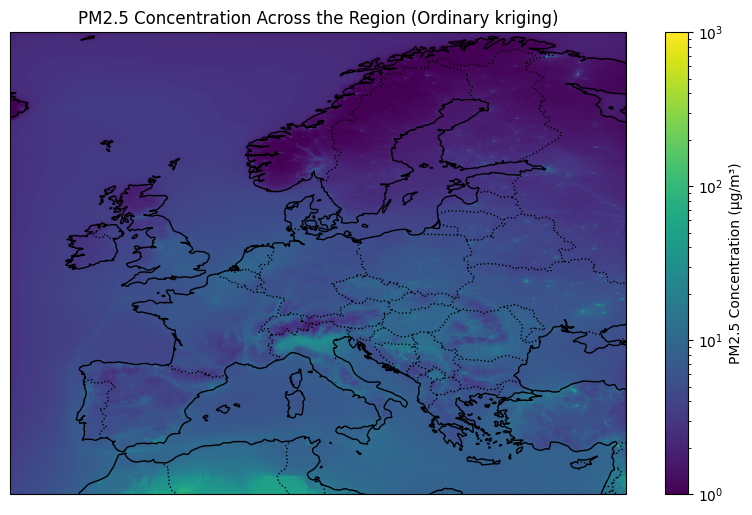

In [ ]:
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import netCDF4

PM25map = netCDF4.Dataset('BC_PERT_PM25_rh50_Y_OK.nc', 'r')  # Replace with the actual file name

# Extract variables: lon, lat, and PM2.5 concentration (first time point)
lon = PM25map.variables['lon'][:]
lat = PM25map.variables['lat'][:]
PM25 = PM25map.variables['SURF_ug_PM25_rh50'][0, :, :]  # Only the first time point

# Close the dataset
PM25map.close()

# Mask out invalid data (_FillValue)
fill_value = 9.969209968386869e+36  # _FillValue for invalid entries
PM25 = np.ma.masked_equal(PM25, fill_value)

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# Define a logarithmic norm
norm = mcolors.LogNorm(vmin=1, vmax=1000)  # Apply logarithmic normalization from 1 to 10000

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM2.5 concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, PM25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with the new scale
plt.colorbar(mesh, label='PM2.5 Concentration (µg/m³)')

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title and labels
plt.title('PM2.5 Concentration Across the Region (Ordinary kriging)')

# Show the plot
plt.show()

# Advanced

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from pykrige.ok import OrdinaryKriging
from tqdm import tqdm
import time
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

# Start Timer
start_time = time.time()

# Load Data
print("Loading data...")
data = pd.read_csv('basePM25nearest_grid.csv')
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')

# Extract Model Data
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].values[0].astype(np.float32)  # Use float32 to reduce memory usage

# Extract Station Data
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# Advanced Kriging Model Selection with Cross-Validation
def cross_validate_kriging_model(models, lon, lat, values):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    best_model, best_score = None, float('inf')

    for model in models:
        errors = []
        for train_idx, test_idx in kf.split(lon):
            lon_train, lon_test = lon[train_idx], lon[test_idx]
            lat_train, lat_test = lat[train_idx], lat[test_idx]
            values_train, values_test = values[train_idx], values[test_idx]

            try:
                OK = OrdinaryKriging(lon_train, lat_train, values_train, variogram_model=model, verbose=False)
                interpolated, _ = OK.execute('grid', lon_test, lat_test)
                error = np.nanmean(np.abs(interpolated - values_test))
                errors.append(error)
            except:
                continue

        avg_error = np.mean(errors)
        if avg_error < best_score:
            best_score, best_model = avg_error, model

    return best_model

print("Selecting the best Kriging model using cross-validation...")
models = ['spherical', 'linear', 'exponential', 'gaussian']
best_model = cross_validate_kriging_model(models, stations_data['lon'].values, stations_data['lat'].values, stations_data['bias'].values)
print(f"Best selected variogram model: {best_model}")

# Function for Block Kriging

def kriging_block(lon_range, lat_range, stations_data, best_model):
    OK_bias = OrdinaryKriging(
        stations_data['lon'].values,
        stations_data['lat'].values,
        stations_data['bias'].values,
        variogram_model=best_model,
        verbose=False,
        enable_plotting=False
    )
    z_bias, _ = OK_bias.execute('grid', lon_range, lat_range)
    return z_bias

# Adaptive Block Size Based on Data Density
num_blocks = 4
lon_splits = np.array_split(model_lons, num_blocks)
lat_splits = np.array_split(model_lats, num_blocks)

print("Interpolating bias using parallel Block Kriging with real-time progress...")
progress_bar = tqdm(total=num_blocks**2, desc="Kriging Progress", position=0, leave=True)

# Perform Block Kriging in Parallel
results = []
for i in range(num_blocks):
    row_blocks = []
    for j in range(num_blocks):
        row_blocks.append(kriging_block(lon_splits[j], lat_splits[i], stations_data, best_model))
        progress_bar.update(1)  # Update progress bar in the main process
    results.append(row_blocks)
progress_bar.close()

# Concatenate blocks properly
z_bias = np.vstack([np.hstack(row) for row in results])

# Trim the final result to match the original shape
z_bias = z_bias[:len(model_lats), :len(model_lons)]

# Apply Bias Correction
print("Applying bias correction to model data...")
corrected_values = model_values + z_bias
corrected_data = model_data.copy()
corrected_data['SURF_ug_PM25_rh50_corrected'] = (['time', 'lat', 'lon'], corrected_values[np.newaxis, :, :])

# Save Corrected Data
print("Saving corrected NetCDF file...")
corrected_data.to_netcdf('BC_PERT_PM25_rh50_Y_OK-A.nc')

# End Timer
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")
